# 30. Машинное обучение в задачах распознавания голоса.

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Сэмплирование сигнала — это процесс преобразования аналогового сигнала в цифровой путем выбора определенного количества сэмплов в секунду из аналогового сигнала.
Загрузим один из многих аудиофайлов с помощью библиотеки librosa. Получим сэмплы и частоту дискретизации (sampling rate)

In [2]:
data_path = 'speech_data/'
samples, sample_rate = librosa.load(data_path+'one/00176480_nohash_0.wav', sr = 16000)

Так выглядят полученные нами сэмплы. Это большой массив чисел

In [3]:
samples

array([-3.0517578e-05, -2.4414062e-04, -7.3242188e-04, ...,
       -9.7656250e-04, -5.1879883e-04, -2.4414062e-04], dtype=float32)

Выведем sample rate:

In [4]:
sample_rate

16000

Как мы видим, в случае с этим аудиофайлом, количество сэмплов равно частоте дискретизации 

In [5]:
len(samples) == sample_rate

True

Отобразим на графике звуковую волну аудиофайла "one"

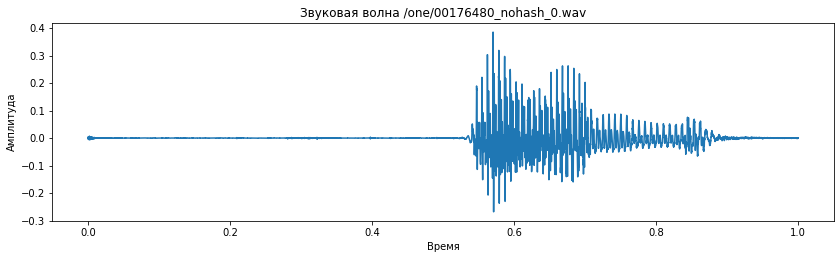

In [6]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Звуковая волна ' + '/one/00176480_nohash_0.wav')
ax1.set_xlabel('Время')
ax1.set_ylabel('Амплитуда')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

С помощью библиотеки IPython прослушаем файл, передав в функцию массив сэмплов и sample rate

In [7]:
ipd.Audio(samples, rate=sample_rate)

Для передачи человеческого голоса обычно допускают частоту дискретизации 8кГц, поэтому с помощью библиотеки librosa изменим sample rate данной аудиозаписи на 8000

In [8]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


Теперь посмотрим, сколько тестовых записей у нас есть для каждого слова

In [9]:
labels=os.listdir(data_path)

In [10]:
labels.pop(labels.index('.ipynb_checkpoints'))
labels.pop(labels.index('.DS_Store'))

'.DS_Store'

In [11]:
labels

['three', 'one', 'two', 'five', 'four']

Для этого создадим пустой словарь, в котором ключами будут слова (или названия папок, в которых лежат эти данные), а значением - количество аудиозаписей

In [12]:
from collections import defaultdict

In [13]:
recordings = defaultdict(int)
for label in labels:
    # проверяем, что label это название папки
    if os.path.isdir(data_path + label):
        # находим все записи для каждого слова
        waves = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
        recordings[label] = (len(waves))

In [14]:
recordings

defaultdict(int,
            {'three': 2356,
             'one': 2370,
             'two': 2373,
             'five': 2357,
             'four': 2372})

Для простоты восприятия отобразим эти данные на гистограмме

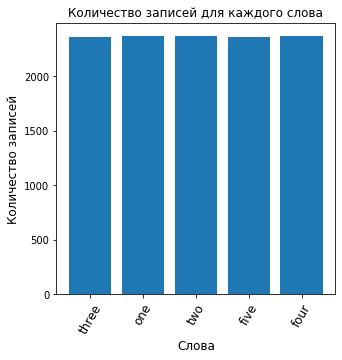

In [15]:
plt.figure(figsize=(5, 5))
index = np.arange(len(recordings))
plt.bar(index, recordings.values())
plt.xlabel('Слова', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.xticks(index, recordings.keys(), fontsize=12, rotation=60)
plt.title('Количество записей для каждого слова')
plt.show()

Посмотрим на продолжительности наших записей. Для этого поделим количество сэмплов на sample rate

In [16]:
durations=[]
for label in labels:
    # проверяем, что label это название папки
    if os.path.isdir(data_path + label):
        # находим все записи для каждого слова
        waves = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
        for wav in waves:
            sample_rate, samples = wavfile.read(data_path + '/' + label + '/' + wav)
            # считаем продолжительность каждой записи
            durations.append(float(len(samples)/sample_rate))

Text(0.5, 1.0, 'Продолжительность аудиозаписей')

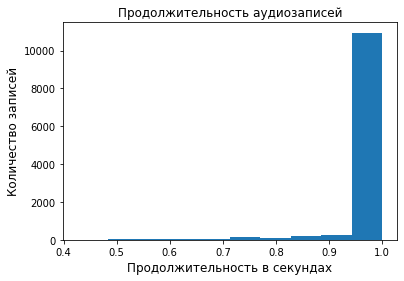

In [17]:
plt.hist(np.array(durations))
plt.xlabel('Продолжительность в секундах', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.title('Продолжительность аудиозаписей')

Как мы видим по гистограмме, у нас есть незначительное количество записей, длина которых меньше 1 секунды. С помощью препроцессинга, у каждой аудиодорожки изменим частоту дискретизации на 8000 и уберем записи, продолжительность которых меньше 1 секунды

In [18]:
waves_preprocessed = []
labels_preprocessed = []
for label in labels:
     # проверяем, что label это название папки
    if os.path.isdir(data_path + label): 
        print('Работаю в папке '+ label)
        # находим все записи для каждого слова
        waves = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
        for wav in waves:
            samples, sample_rate = librosa.load(data_path + '/' + label + '/' + wav, sr = 16000)
            # меняем частоту дискретизации
            samples = librosa.resample(samples, sample_rate, 8000)
            # оставляем только записи, длиной в 1 секунду
            if(len(samples)== 8000): 
                waves_preprocessed.append(samples)
                labels_preprocessed.append(label)

Работаю в папке three


/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  if __name__ == '__main__':


Работаю в папке one
Работаю в папке two
Работаю в папке five
Работаю в папке four


Преобразуем названия наших категорий слов в числовые признаки с помощью инструмента LabelEncoder из библиотеки sklearn.preprocessing

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(labels_preprocessed)
classes= list(le.classes_)

In [20]:
np.array(classes)

array(['five', 'four', 'one', 'three', 'two'], dtype='<U5')

In [21]:
print(y, len(y))

[3 3 3 ... 1 1 1] 10705


In [22]:
from keras.utils import to_categorical
y=to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [23]:
print(y, len(y))

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]] 10705


Преобразуем 2D массив в 3D, так как в дальнейшем нам понадобится именно он

In [24]:
waves_preprocessed = np.array(waves_preprocessed).reshape(-1,8000,1)

После преобразований получаем массив "y" (массив бинарных представлений категорий) и 3D массив "waves_preprocessed" (массивы 8000 сэмплов на каждую аудиодорожку)

Пример - бинарное представление категории "three"

In [25]:
y[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [26]:
classes[np.argmax(y[0])]

'three'

Массив сэмплов аудиодорожки, которая относится к слову "three"

In [27]:
waves_preprocessed[0]

array([[0.00050792],
       [0.00107822],
       [0.00100044],
       ...,
       [0.0021863 ],
       [0.00225723],
       [0.00174034]], dtype=float32)

In [28]:
ipd.Audio(waves_preprocessed[0].ravel(), rate=8000)

# Модель 1

In [37]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization

Разделим набор данных на обучающую и тестовую выборки с помощью инструмента train_test_split

In [49]:
X_train, X_validation, y_train, y_validation = train_test_split(waves_preprocessed, y, test_size=0.2)
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

In [74]:
model2 = Sequential()

# сверточная часть, для извлечения характерных признаков
model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(8000, 1, 1), padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))                     
model2.add(BatchNormalization())
model2.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model2.add(Conv2D(32, (2, 2), activation='relu', padding='same'))                                
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# преобразуем двумерные данные в одномерные, т.к полносвязный слой не может работать
# с двумерными данными. преобразует матрицу в вектор, записывая данные друг за другом
model2.add(Flatten())

# полносвязная часть, для классификации признаков, извлеченных в сверточной части
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))

#  1 нейрон на один label
model2.add(Dense(len(labels), activation='softmax'))

model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 8000, 1, 64)       640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 8000, 1, 64)       256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4000, 1, 64)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4000, 1, 32)       18464     
_________________________________________________________________
batch_normalization_11 (Batc (None, 4000, 1, 32)       128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2000, 1, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2000, 1, 32)      

In [54]:
mc2 = ModelCheckpoint('models/Conv2D.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1, mode='max')

In [55]:
%%time
history2=model2.fit(X_train, y_train ,epochs=5, callbacks=[mc2], batch_size=32,
                    validation_data=(X_validation,y_validation))


Train on 8564 samples, validate on 2141 samples
Epoch 1/5
8564/8564 [==============================] - 1426s 166ms/step - loss: 2.1327 - accuracy: 0.3765 - val_loss: 24.4758 - val_accuracy: 0.2106

Epoch 00001: saving model to models/Conv2D.01-24.48.hdf5
Epoch 2/5
8564/8564 [==============================] - 1519s 177ms/step - loss: 1.1441 - accuracy: 0.5097 - val_loss: 12.1321 - val_accuracy: 0.2279

Epoch 00002: saving model to models/Conv2D.02-12.13.hdf5
Epoch 3/5
8564/8564 [==============================] - 1492s 174ms/step - loss: 1.0476 - accuracy: 0.5800 - val_loss: 5.6895 - val_accuracy: 0.3947

Epoch 00003: saving model to models/Conv2D.03-5.69.hdf5
Epoch 4/5
8564/8564 [==============================] - 1504s 176ms/step - loss: 0.8109 - accuracy: 0.6617 - val_loss: 1.7488 - val_accuracy: 0.5549

Epoch 00004: saving model to models/Conv2D.04-1.75.hdf5
Epoch 5/5
8564/8564 [==============================] - 1442s 168ms/step - loss: 0.7113 - accuracy: 0.7144 - val_loss: 5.1181 - v

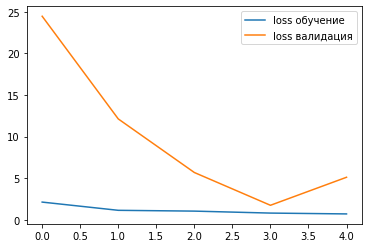

In [89]:
from matplotlib import pyplot
pyplot.plot(history2.history['loss'], label='loss обучение')
pyplot.plot(history2.history['val_loss'], label='loss валидация')
pyplot.legend()
pyplot.show()

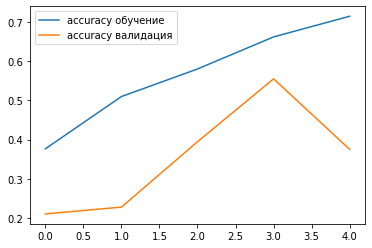

In [90]:
pyplot.plot(history2.history['accuracy'], label='accuracy обучение')
pyplot.plot(history2.history['val_accuracy'], label='accuracy валидация')
pyplot.legend()
pyplot.show()

# Модель 1. Изменим входные данные

Проверим, что данные были в первоначальном порядке

In [95]:
classes[np.argmax(y_train[0])]

'five'

In [96]:
classes[np.argmax(y_train[1])]

'five'

In [104]:
classes[np.argmax(y_train[2])]

'five'

In [56]:
X_train2, X_validation2, y_train2, y_validation2 = train_test_split(
    waves_preprocessed, 
    y, 
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True)
X_train2 = X_train2[..., np.newaxis]
X_validation2 = X_validation2[..., np.newaxis]

/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

Убедимся, что данные перемешались

In [106]:
classes[np.argmax(y_train2[0])]

'one'

In [108]:
classes[np.argmax(y_train2[1])]

'five'

In [109]:
classes[np.argmax(y_train2[2])]

'three'

In [57]:
mc3 = ModelCheckpoint('models/Conv2D-2.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1, mode='max')

In [68]:
%%time
history3=model2.fit(X_train2, y_train2 ,epochs=5, callbacks=[mc3], batch_size=32,
                    validation_data=(X_validation2, y_validation2))

Train on 8564 samples, validate on 2141 samples
Epoch 1/5
8564/8564 [==============================] - 1380s 161ms/step - loss: 0.7216 - accuracy: 0.7355 - val_loss: 3.2036 - val_accuracy: 0.6240

Epoch 00001: saving model to models/Conv2D-2.01-3.20.hdf5
Epoch 2/5
8564/8564 [==============================] - 1420s 166ms/step - loss: 0.6059 - accuracy: 0.7781 - val_loss: 0.9748 - val_accuracy: 0.6371

Epoch 00002: saving model to models/Conv2D-2.02-0.97.hdf5
Epoch 3/5
8564/8564 [==============================] - 1452s 170ms/step - loss: 0.4997 - accuracy: 0.8122 - val_loss: 3.1440 - val_accuracy: 0.5091

Epoch 00003: saving model to models/Conv2D-2.03-3.14.hdf5
Epoch 4/5
8564/8564 [==============================] - 1457s 170ms/step - loss: 0.4550 - accuracy: 0.8273 - val_loss: 2.0920 - val_accuracy: 0.6576

Epoch 00004: saving model to models/Conv2D-2.04-2.09.hdf5
Epoch 5/5
8564/8564 [==============================] - 1426s 167ms/step - loss: 0.4305 - accuracy: 0.8413 - val_loss: 1.3477

# Модель 2

In [75]:
from keras.regularizers import l2

model3 = Sequential()

# Conv2D(степени двойки - увеличиваем, нечетные (3, 3))
model3.add(Conv2D(8, (3, 3), activation='relu', input_shape=(8000, 1, 1), padding='same', kernel_regularizer=l2(0.0005)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model3.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))                     
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))                                
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(len(labels), activation='softmax'))

model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 8000, 1, 8)        80        
_________________________________________________________________
batch_normalization_13 (Batc (None, 8000, 1, 8)        32        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4000, 1, 8)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4000, 1, 16)       1168      
_________________________________________________________________
batch_normalization_14 (Batc (None, 4000, 1, 16)       64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2000, 1, 16)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 2000, 1, 32)      

In [76]:
mc4 = ModelCheckpoint('models/Conv2D-3.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1, mode='max')

In [77]:
%%time
history4=model3.fit(X_train2, y_train2 ,epochs=5, callbacks=[mc4], batch_size=32,
                    validation_data=(X_validation2, y_validation2))

Train on 8564 samples, validate on 2141 samples
Epoch 1/5
8564/8564 [==============================] - 308s 36ms/step - loss: 1.7737 - accuracy: 0.4337 - val_loss: 10.4775 - val_accuracy: 0.1999

Epoch 00001: saving model to models/Conv2D-3.01-10.48.hdf5
Epoch 2/5
8564/8564 [==============================] - 321s 37ms/step - loss: 0.9670 - accuracy: 0.6100 - val_loss: 1.9609 - val_accuracy: 0.3424

Epoch 00002: saving model to models/Conv2D-3.02-1.96.hdf5
Epoch 3/5
8564/8564 [==============================] - 324s 38ms/step - loss: 0.7749 - accuracy: 0.6986 - val_loss: 1.2874 - val_accuracy: 0.5255

Epoch 00003: saving model to models/Conv2D-3.03-1.29.hdf5
Epoch 4/5
8564/8564 [==============================] - 322s 38ms/step - loss: 0.6204 - accuracy: 0.7639 - val_loss: 1.8805 - val_accuracy: 0.6114

Epoch 00004: saving model to models/Conv2D-3.04-1.88.hdf5
Epoch 5/5
8564/8564 [==============================] - 327s 38ms/step - loss: 0.5381 - accuracy: 0.7904 - val_loss: 1.0898 - val_a

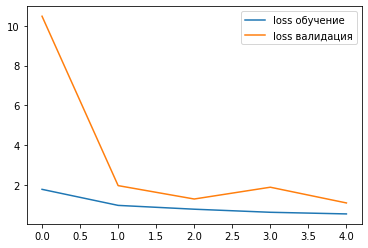

In [110]:
from matplotlib import pyplot
pyplot.plot(history4.history['loss'], label='loss обучение')
pyplot.plot(history4.history['val_loss'], label='loss валидация')
pyplot.legend()
pyplot.show()

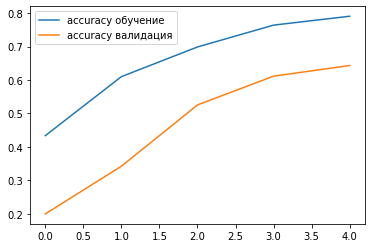

In [111]:
pyplot.plot(history4.history['accuracy'], label='accuracy обучение')
pyplot.plot(history4.history['val_accuracy'], label='accuracy валидация')
pyplot.legend()
pyplot.show()

# Модель 3

In [81]:
from keras.regularizers import l2

model4 = Sequential()

# Conv2D(степени двойки - увеличиваем, нечетные (3, 3))
model4.add(Conv2D(16, (3, 3), activation='relu', input_shape=(8000, 1, 1), padding='same', kernel_regularizer=l2(0.0005)))
model4.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model4.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))                     
model4.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model4.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))                                
model4.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model4.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))                                
model4.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model4.add(Flatten())

model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(len(labels), activation='softmax'))

model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 8000, 1, 16)       160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4000, 1, 16)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4000, 1, 32)       4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2000, 1, 32)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2000, 1, 64)       18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1000, 1, 64)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1000, 1, 64)      

In [82]:
mc6 = ModelCheckpoint('models/Conv2D-4.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1, mode='max')

In [83]:
%%time
history6=model4.fit(X_train2, y_train2 ,epochs=5, callbacks=[mc6], batch_size=32,
                    validation_data=(X_validation2, y_validation2))

Train on 8564 samples, validate on 2141 samples
Epoch 1/5
8564/8564 [==============================] - 582s 68ms/step - loss: 1.3234 - accuracy: 0.3900 - val_loss: 1.0564 - val_accuracy: 0.5348

Epoch 00001: saving model to models/Conv2D-4.01-1.06.hdf5
Epoch 2/5
8564/8564 [==============================] - 606s 71ms/step - loss: 0.9750 - accuracy: 0.5715 - val_loss: 0.8903 - val_accuracy: 0.6343

Epoch 00002: saving model to models/Conv2D-4.02-0.89.hdf5
Epoch 3/5
8564/8564 [==============================] - 620s 72ms/step - loss: 0.7981 - accuracy: 0.6606 - val_loss: 0.7754 - val_accuracy: 0.6978

Epoch 00003: saving model to models/Conv2D-4.03-0.78.hdf5
Epoch 4/5
8564/8564 [==============================] - 656s 77ms/step - loss: 0.6501 - accuracy: 0.7360 - val_loss: 0.6693 - val_accuracy: 0.7454

Epoch 00004: saving model to models/Conv2D-4.04-0.67.hdf5
Epoch 5/5
8564/8564 [==============================] - 634s 74ms/step - loss: 0.5287 - accuracy: 0.7973 - val_loss: 0.5922 - val_acc

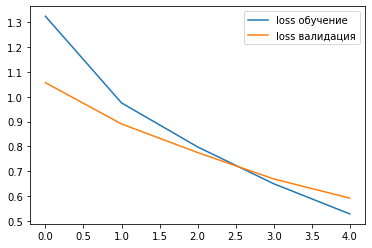

In [112]:
from matplotlib import pyplot
pyplot.plot(history6.history['loss'], label='loss обучение')
pyplot.plot(history6.history['val_loss'], label='loss валидация')
pyplot.legend()
pyplot.show()

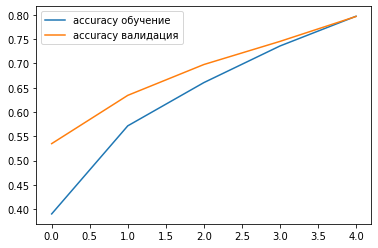

In [113]:
pyplot.plot(history6.history['accuracy'], label='accuracy обучение')
pyplot.plot(history6.history['val_accuracy'], label='accuracy валидация')
pyplot.legend()
pyplot.show()

# Модель 4

In [29]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
    waves_preprocessed,
    y,
    stratify=y,
    test_size = 0.2,
    random_state=42,
    shuffle=True)

/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

Conv1D (Convolution 1-Dimensional) - создание одномерных сверточных слоев.
1-й параметр - кол-во ядер свертки.
2-й параметр - длина окна свертки.
Активация relu - полулинейная функция .
Чтобы размерность данных не уменьшалась, используем padding

MaxPooling1D - слой подвыборки с выбором макс. значения.
Размер пула 3 - слой подключен к 3-м нейронам на предыдущем сверточном слое и выбирает из них 1 макс. значение, которое передается в следующий сверточный слой

In [32]:
from keras.models import Model
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, Input
from keras.callbacks import ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

conv = Flatten()(conv)

conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [33]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [34]:
mc = ModelCheckpoint('models/Conv1D.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1, mode='max')

In [35]:
%%time
history=model.fit(x_tr, y_tr ,epochs=5, callbacks=[mc], batch_size=32, validation_data=(x_val,y_val))

Train on 8564 samples, validate on 2141 samples
Epoch 1/5
8564/8564 [==============================] - 122s 14ms/step - loss: 1.3072 - accuracy: 0.3883 - val_loss: 1.2175 - val_accuracy: 0.4596

Epoch 00001: saving model to models/Conv1D.01-1.22.hdf5
Epoch 2/5
8564/8564 [==============================] - 126s 15ms/step - loss: 0.9670 - accuracy: 0.5689 - val_loss: 0.8552 - val_accuracy: 0.6175

Epoch 00002: saving model to models/Conv1D.02-0.86.hdf5
Epoch 3/5
8564/8564 [==============================] - 129s 15ms/step - loss: 0.7579 - accuracy: 0.6730 - val_loss: 0.7358 - val_accuracy: 0.7319

Epoch 00003: saving model to models/Conv1D.03-0.74.hdf5
Epoch 4/5
8564/8564 [==============================] - 131s 15ms/step - loss: 0.6091 - accuracy: 0.7515 - val_loss: 0.5623 - val_accuracy: 0.7945

Epoch 00004: saving model to models/Conv1D.04-0.56.hdf5
Epoch 5/5
8564/8564 [==============================] - 131s 15ms/step - loss: 0.5216 - accuracy: 0.8032 - val_loss: 0.4479 - val_accuracy: 0

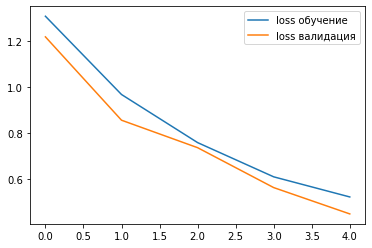

In [115]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='loss обучение')
pyplot.plot(history.history['val_loss'], label='loss валидация')
pyplot.legend()
pyplot.show()

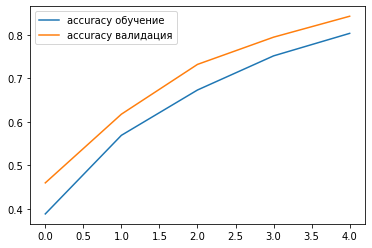

In [116]:
pyplot.plot(history.history['accuracy'], label='accuracy обучение')
pyplot.plot(history.history['val_accuracy'], label='accuracy валидация')
pyplot.legend()
pyplot.show()

In [79]:
mc5 = ModelCheckpoint('models/Conv1D-2.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', verbose=1, mode='max')

In [80]:
history5=model.fit(x_tr, y_tr ,epochs=40, callbacks=[mc], batch_size=32, validation_data=(x_val,y_val))

Train on 8564 samples, validate on 2141 samples
Epoch 1/40
8564/8564 [==============================] - 129s 15ms/step - loss: 0.4501 - accuracy: 0.8347 - val_loss: 0.4598 - val_accuracy: 0.8431

Epoch 00001: saving model to models/Conv1D.01-0.46.hdf5
Epoch 2/40
8564/8564 [==============================] - 128s 15ms/step - loss: 0.3909 - accuracy: 0.8542 - val_loss: 0.4016 - val_accuracy: 0.8603

Epoch 00002: saving model to models/Conv1D.02-0.40.hdf5
Epoch 3/40
8564/8564 [==============================] - 128s 15ms/step - loss: 0.3659 - accuracy: 0.8692 - val_loss: 0.3745 - val_accuracy: 0.8716

Epoch 00003: saving model to models/Conv1D.03-0.37.hdf5
Epoch 4/40
8564/8564 [==============================] - 128s 15ms/step - loss: 0.3240 - accuracy: 0.8836 - val_loss: 0.3577 - val_accuracy: 0.8725

Epoch 00004: saving model to models/Conv1D.04-0.36.hdf5
Epoch 5/40
8564/8564 [==============================] - 128s 15ms/step - loss: 0.2871 - accuracy: 0.8960 - val_loss: 0.3124 - val_accura


Epoch 00040: saving model to models/Conv1D.40-0.31.hdf5


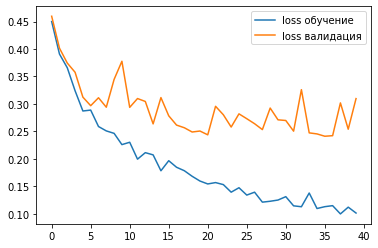

In [117]:
from matplotlib import pyplot
pyplot.plot(history5.history['loss'], label='loss обучение')
pyplot.plot(history5.history['val_loss'], label='loss валидация')
pyplot.legend()
pyplot.show()

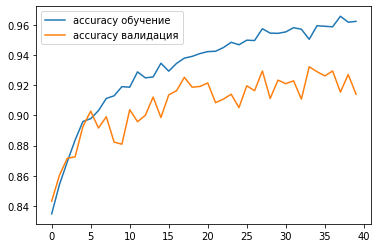

In [118]:
pyplot.plot(history5.history['accuracy'], label='accuracy обучение')
pyplot.plot(history5.history['val_accuracy'], label='accuracy валидация')
pyplot.legend()
pyplot.show()

# Проверяем работоспособонсть модель

In [119]:
from keras.models import load_model
model=load_model('models/Conv1D.34-0.25.hdf5')

In [142]:
X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(
    waves_preprocessed, 
    y, 
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True)

/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

In [143]:
test_loss, test_acc = model.evaluate(X_test_ev, y_test_ev)

2141/2141 [==============================] - 12s 6ms/step


In [144]:
test_loss

0.24728033060555088

In [145]:
test_acc

0.9322746396064758

In [177]:
def predict(audio):
    pred=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(pred[0])
    return classes[index]

In [178]:
import random
index=random.randint(0,len(X_test_ev)-1)
samples=X_test_ev[index].ravel()
print("Слово:",classes[np.argmax(y_test_ev[index])])
ipd.Audio(samples, rate=8000)

Слово: five


In [179]:
print("Распознование слова:",predict(samples))

Распознование слова: five


In [159]:
filepath = '/Users/dimitry/JupyterProjects/voice/'

In [202]:
import sounddevice as sd
import soundfile as sf

def record(filename):
    samplerate = 16000  
    duration = 1
    filename = 'custom/' + filename + '.wav'
    print("Начало записи")
    mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
        channels=1, blocking=True)
    print("Конец записи")
    sd.wait()
    sf.write(filename, mydata, samplerate)
    
    samples, sample_rate = librosa.load(filepath + '/' + filename, sr = 16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    print("Вы произнесли слово " + predict(samples))
    return ipd.Audio(samples,rate=8000)

In [212]:
record("one")

Начало записи
Конец записи
Вы произнесли слово one


/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  app.launch_new_instance()


In [213]:
record("two")

Начало записи
Конец записи
Вы произнесли слово two


/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  app.launch_new_instance()


In [215]:
record("three")

Начало записи
Конец записи
Вы произнесли слово three


/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  app.launch_new_instance()


In [208]:
record("four")

Начало записи
Конец записи
Вы произнесли слово four


/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  app.launch_new_instance()


In [210]:
record("five")

Начало записи
Конец записи
Вы произнесли слово five


/Users/dimitry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  app.launch_new_instance()
